<a href="https://colab.research.google.com/github/Jonny-T87/Dojo-Work/blob/main/Jonny_Intro_to_Gradient_Boosting_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jonny Tesfahun
- 07/12/22

# Intro to Gradient Boosting

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [155]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

The data is available [here](https://drive.google.com/file/d/1drlRzq-lIY7rxQnvv_3fsxfIfLsjQ4A-/view?usp=sharing)

In [157]:
df = pd.read_csv('/content/drive/MyDrive/DojoBootCamp/Project Files/census_income - census_income.csv')
df.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Prepare your dataset for modeling.

Remember to: 
1. Check for missing data, bad data, and duplicates.
2. Check your target class balance.
3. Perform your validation split
4. Create a preprocessing pipeline to use with your models.
5. Fit and evaluate your models using pipelines

1.

In [158]:
df.duplicated().sum()

0

In [159]:
df.isna().sum()

Unnamed: 0        0
age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income-class      0
dtype: int64

In [160]:
df.describe()

,Unnamed: 0,age,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,16280.000000,38.581647,1077.648844,87.303830,40.437456
std,9399.695394,13.640433,7385.292085,402.960219,12.347429
min,0.000000,17.000000,0.000000,0.000000,1.000000
25%,8140.000000,28.000000,0.000000,0.000000,40.000000
50%,16280.000000,37.000000,0.000000,0.000000,40.000000
75%,24420.000000,48.000000,0.000000,0.000000,45.000000
max,32560.000000,90.000000,99999.000000,4356.000000,99.000000


2.

In [161]:
df['income-class'].value_counts()

<=50K    24720
>50K      7841
Name: income-class, dtype: int64

In [162]:
df.corr()

,Unnamed: 0,age,capital-gain,capital-loss,hours-per-week
Unnamed: 0,1.000000,0.001286,0.001672,-0.001188,0.000607
age,0.001286,1.000000,0.077674,0.057775,0.068756
capital-gain,0.001672,0.077674,1.000000,-0.031615,0.078409
capital-loss,-0.001188,0.057775,-0.031615,1.000000,0.054256
hours-per-week,0.000607,0.068756,0.078409,0.054256,1.000000


3.

In [163]:
df['sex'].value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

In [164]:
#droping not needed column
df.drop(columns='Unnamed: 0', inplace=True)
#Ordinal maping Sex column
df['sex'] = df['sex'].map({'Male':0, 'Female':1})

In [165]:
#Target and features
X = df.drop(columns='income-class')
y = df['income-class']

In [166]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

4.

In [167]:
#column selector for numbers and object
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [168]:
#scaler for numbers and OHE for objects
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [169]:
#create imputer for both
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

In [170]:
#num pipeline
num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [171]:
#cat pipeline
cat_pipe = make_pipeline(freq_imputer, ohe)
cat_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [172]:
#making tuples for each
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [173]:
preprocessing = make_column_transformer(num_tuple, cat_tuple)
preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc150>

In [174]:
#fitting to train data, learning 
preprocessing.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc150>

In [175]:
#Using ColumnTransformer to transform both the training and testing datasets.
X_train_processed = preprocessing.transform(X_train)
X_test_processed = preprocessing.transform(X_test)

In [176]:
#Checking if done right on training data, looks good
X_train_processed

array([[ 0.76270329, -0.70437219, -0.14599394, ...,  1.        ,
         0.        ,  0.        ],
       [-0.85041534, -0.70437219, -0.14599394, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.39608542, -0.70437219, -0.14599394, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.51032751,  1.41970398, -0.14599394, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.83602687, -0.70437219, -0.14599394, ...,  1.        ,
         0.        ,  0.        ],
       [-0.33715032, -0.70437219, -0.14599394, ...,  1.        ,
         0.        ,  0.        ]])

In [177]:
#Source from class lecture in codealong
#Printing data for easy viewing and validation
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (24420, 105)




# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [178]:
xgb = XGBClassifier()

In [179]:
xgb_pipe = make_pipeline(preprocessing, xgb)

In [180]:
#Testing time
%%time
xgb_pipe.fit(X_train, y_train)

CPU times: user 5.21 s, sys: 58.1 ms, total: 5.27 s
Wall time: 5.28 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc250>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncode

In [181]:
xgb_acc_train_score = xgb_pipe.score(X_train, y_train)
xgb_acc_test_score = xgb_pipe.score(X_test, y_test)
print(f" Train Score: {xgb_acc_train_score}")
print(f"Test Score: {xgb_acc_test_score}")

 Train Score: 0.8642506142506142
Test Score: 0.8662326495516521


In [182]:
xgb_predict = xgb_pipe.predict(X_test)
xgb_predict

array(['<=50K', '<=50K', '>50K', ..., '<=50K', '>50K', '<=50K'],
      dtype=object)

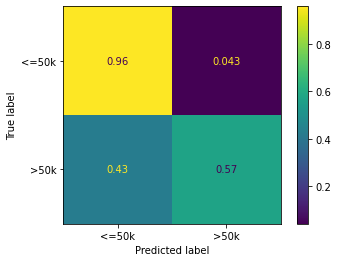

In [183]:
labels=['<=50k','>50k']
ConfusionMatrixDisplay.from_predictions(y_test, xgb_predict, display_labels=labels, normalize='true');

In [184]:

#print('Precision: %.3f' % precision_score(y_test, xgb_predict))
#print('Recall: %.3f' % recall_score(y_test, xgb_predict))
#print('F1 Score: %.3f' % f1_score(y_test, xgb_predict))

Which target class is your model better at predicting?  Is it significantly overfit?

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

In [185]:
lGBM = LGBMClassifier()
lGBM_pipe = make_pipeline(preprocessing, lGBM)

In [186]:
%%time
lGBM_pipe.fit(X_train, y_train)

CPU times: user 565 ms, sys: 17.7 ms, total: 583 ms
Wall time: 592 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc250>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncode

In [187]:
lGBM_acc_train_score = lGBM_pipe.score(X_train, y_train)
lGBM_acc_test_score = lGBM_pipe.score(X_test, y_test)
print(f" Train Score: {lGBM_acc_train_score}")
print(f"Test Score: {lGBM_acc_test_score}")

 Train Score: 0.8861588861588862
Test Score: 0.8776563075789215


In [188]:
lGBM_predict = lGBM_pipe.predict(X_test)
lGBM_predict

array(['<=50K', '>50K', '>50K', ..., '<=50K', '>50K', '>50K'],
      dtype=object)

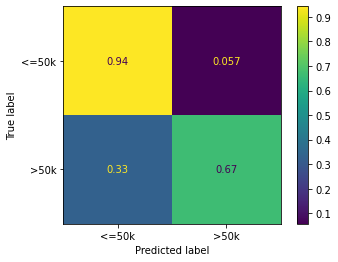

In [189]:
labels=['<=50k','>50k']
ConfusionMatrixDisplay.from_predictions(y_test, lGBM_predict, display_labels=labels, normalize='true');

## GradientBoostingClassifier

In [190]:
gbc = GradientBoostingClassifier()

In [191]:
gbc_pipe = make_pipeline(preprocessing, gbc)

In [192]:
%%time
gbc_pipe.fit(X_train, y_train)

CPU times: user 5.53 s, sys: 5.37 ms, total: 5.53 s
Wall time: 5.52 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc250>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncode

In [193]:
gbc_acc_train_score = gbc_pipe.score(X_train, y_train)
gbc_acc_test_score = gbc_pipe.score(X_test, y_test)
print(f" Train Score: {gbc_acc_train_score}")
print(f"Test Score: {gbc_acc_test_score}")

 Train Score: 0.8681408681408681
Test Score: 0.8680751750399214


In [194]:
gbc_predict = gbc_pipe.predict(X_test)
gbc_predict

array(['<=50K', '>50K', '>50K', ..., '<=50K', '>50K', '<=50K'],
      dtype=object)

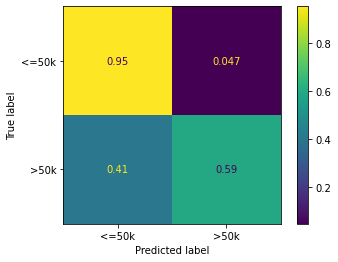

In [453]:
labels=['<=50k','>50k']
ConfusionMatrixDisplay.from_predictions(y_test, gbc_predict, display_labels=labels, normalize='true');

In [196]:
#Recall Score = #5925 / (5925 + 785) = 5925 / 6710 = 0.883
#Precision Score = #5925 / (1142 + 5925) = 7067 = 0.838
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score) # 


# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


In [197]:
lGBM.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [444]:
lGBM_tune = LGBMClassifier(class_weight=None, num_leaves=89, max_depth=32, n_estimators=400)
lGBM_tune_pipe = make_pipeline(preprocessing, lGBM_tune)

In [445]:
%%time
lGBM_tune_pipe.fit(X_train, y_train)

CPU times: user 1.99 s, sys: 65.8 ms, total: 2.05 s
Wall time: 2.06 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc4e0ebc250>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncode

In [446]:
lGBM_tune_acc_train_score = lGBM_tune_pipe.score(X_train, y_train)
lGBM_tune_acc_test_score = lGBM_tune_pipe.score(X_test, y_test)
print(f" Train Score: {lGBM_tune_acc_train_score}")
print(f"Test Score: {lGBM_tune_acc_test_score}")

 Train Score: 0.9509418509418509
Test Score: 0.8683208451050239


# Evaluation

Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

In [447]:
lGBM_tune_predict = lGBM_tune_pipe.predict(X_test)
lGBM_tune_predict

array(['<=50K', '>50K', '>50K', ..., '<=50K', '>50K', '<=50K'],
      dtype=object)

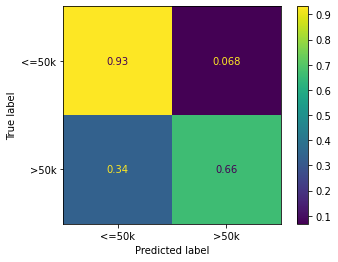

In [452]:
labels=['<=50k','>50k']
ConfusionMatrixDisplay.from_predictions(y_test, lGBM_tune_predict, display_labels=labels, normalize='true');

The computation time of that model is maybe a second longer to load. The model performed good in terms of precision and recall. With 0.819 for precision and 0.898 for recall . The accurecy of the model after tuning was also very close to none tuned model.

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

